In [4]:
pip install keras

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2
import random
import os
from os import listdir
from PIL import Image
from sklearn.preprocessing import label_binarize, LabelBinarizer
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dropout, Dense
from sklearn.model_selection import train_test_split
from keras.models import model_from_json
from tensorflow.keras.utils import to_categorical

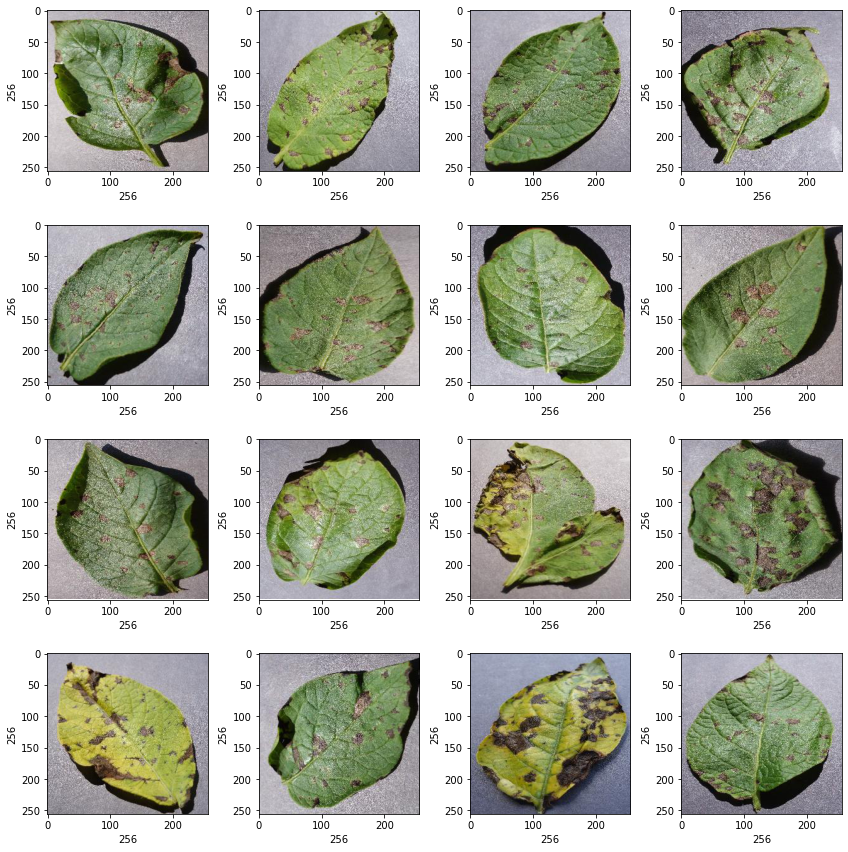

In [11]:
# Plotting 10 images to check the dataset
plt.figure(figsize=(12,12))
path = "/content/sample_data/Plant_images_pianalytix/Potato___Early_blight"
for i in range(1, 17):
  plt.subplot(4,4,i)
  plt.tight_layout()
  rand_img = imread(path + '/'+random.choice(sorted(os.listdir(path))))
  plt.imshow(rand_img)
  plt.xlabel(rand_img.shape[1], fontsize = 10)
  plt.ylabel(rand_img.shape[0], fontsize = 10)

In [12]:
# Convert images to arrays
def convert_img_toArray(image_dir):
  try:
    image = cv2.imread(image_dir)
    if image is not None:
      image = cv2.resize(image, (256, 256))
      return img_to_array(image)
    else:
      return np.array([])
  except Exception as e:
    print(f"Error: {e}")
    return None

In [14]:
dir = "/content/sample_data/Plant_images_pianalytix"
root_dir = listdir(dir)
image_list, label_list = [], []
all_labels = ['Corn-Common_rust', 'Potato-Early_blight', 'Tomato-Bacterial_spot']
binary_labels = [0,1,2]
temp = -1

# Read image and casting into numpy array
for directory in root_dir:
  plant_image_list = listdir(f"{dir}/{directory}")
  temp += 1
  for files in plant_image_list:
    image_path = f"{dir}/{directory}/{files}"
    image_list.append(convert_img_toArray(image_path))
    label_list.append(binary_labels[temp])

In [15]:
# Visualize the number of classes count
label_counts = pd.DataFrame(label_list).value_counts()
label_counts.head()

0    300
1    300
2    300
dtype: int64

In [16]:
image_list[0].shape

(256, 256, 3)

In [17]:
label_list = np.array(label_list)
label_list.shape

(900,)

In [21]:
x_train, x_test, y_train, y_test = train_test_split(image_list, label_list, test_size=0.25, random_state=10)

In [22]:
x_train = np.array(x_train, dtype=np.float16) / 225.0
x_test = np.array(x_test, dtype=np.float16) / 225.0
x_train = x_train.reshape(-1, 256, 256, 3)
x_test = x_test.reshape(-1, 256, 256, 3)

In [23]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [24]:
model = Sequential()
model.add(Conv2D(32, (3,3), padding="same", input_shape=(256, 256, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Conv2D(64, (3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dense(3, activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 42, 42, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 112896)            0         
                                                                 
 dense (Dense)               (None, 64)                7

In [25]:
model.compile(loss = "categorical_crossentropy", optimizer=Adam(0.0001), metrics=['accuracy'])

In [26]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.25)

In [ ]:
# Training of the model
epochs = 50
batch_size = 128
history = model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs, validation_data=(x_val, y_val))

In [30]:
model.save("/content/plant_disease.h5")

# Serialize model to JSON
json_model = model.to_json()

# Save model architecture to JSON file
with open('/content/plant_model.json', 'w') as json_file:
  json_file.write(json_model)

# Save the weights of the model
model.save_weights('/content/plant_model_weights.h5')

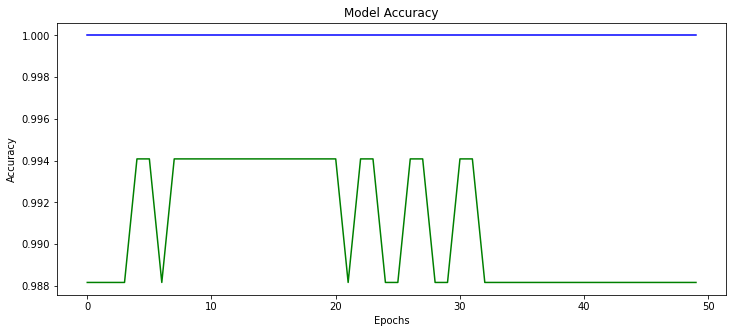

In [31]:
# Plot the training history
plt.figure(figsize=(12,5))
plt.plot(history.history['accuracy'], color='b')
plt.plot(history.history['val_accuracy'], color='g')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.show()

In [32]:
print("[INFORMATION] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFORMATION] Calculating model accuracy
8/8 [==============================] - 3s 417ms/step - loss: 0.0101 - accuracy: 0.9956
Test Accuracy: 99.5555579662323


In [33]:
y_pred = model.predict(x_test)

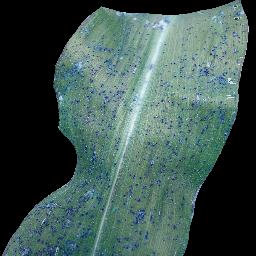

In [34]:
img = array_to_img(x_test[10])
img

In [35]:
print("Originally: ", all_labels[np.argmax(y_test[10])])
print("Predicted: ", all_labels[np.argmax(y_pred[10])])

Originally:  Potato-Early_blight
Predicted:  Potato-Early_blight
